
# Planificador de jornada del estudiante (A* y Branch & Bound)

Este notebook implementa el **modelo y los algoritmos** para el proyecto de final de la materia.



## 1) Definición del problema

Nuestri problema plantea que un estudiante dispone de un tiempo limitado durante el día y debe decidir qué actividades realizar para aprovechar al máximo su jornada.

Cada actividad tiene una utilidad/valor, una duración y una ventana de tiempo en la que puede hacerse. El objetivo es maximizar la utilidad total del día, teniendo en cuenta que, además, existen tiempos de traslado entre actividades, los cuales se tienen en cuenta como una penalización.


## 2) Clases de datos


In [1]:

from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Set
import heapq

"""
Clase que representa a una actividad concreta del dia no importa que se realice o no (ejemplo gimnasio, trabajo, ocio, etc). 
"""
@dataclass(frozen=True)
class Activity:
    id: int
    name: str
    value: float
    duration: float
    open_time: float
    close_time: float

@dataclass
class Instance:
    activities: List[Activity]
    travel_time: List[List[float]]
    Tmax: float # Maximo tiempo disponible en el dia
    alpha: float = 0.0 # Penalizacion por tiempo de viaje
    start_id: Optional[int] = None

    def __post_init__(self):
        n = len(self.activities)
        assert len(self.travel_time) == n and all(len(row) == n for row in self.travel_time)
        self.id_to_idx = {a.id: i for i, a in enumerate(self.activities)}

    def idx(self, act_id: int) -> int:
        return self.id_to_idx[act_id]

    def d(self, from_id: int, to_id: int) -> float:
        return self.travel_time[self.idx(from_id)][self.idx(to_id)]

    def activity_by_id(self, act_id: int) -> Activity:
        return self.activities[self.idx(act_id)]


@dataclass(order=True)
class State:
    priority: float
    current_id: int = field(compare=False)
    time: float = field(compare=False)
    collected_value: float = field(compare=False)
    travel_cost: float = field(compare=False)
    visited: frozenset = field(compare=False)
    route: Tuple[int, ...] = field(compare=False)

    def total_objective(self, alpha: float) -> float:
        return self.collected_value - alpha * self.travel_cost



## 3) Factibilidad y utilidades


In [2]:

from typing import Optional, Tuple

def feasible_transition(inst: Instance, from_id: int, to_id: int, current_time: float) -> Optional[Tuple[float, float]]:
    act_j = inst.activity_by_id(to_id)
    travel = inst.d(from_id, to_id)
    arrive = current_time + travel
    start = max(arrive, act_j.open_time)
    if start > act_j.close_time:
        return None
    finish = start + act_j.duration
    if finish > inst.Tmax:
        return None
    return (start, finish)

def upper_bound_value(inst: Instance, state: State) -> float:
    remaining_time = inst.Tmax - state.time
    ub = state.collected_value
    remaining = [a for a in inst.activities if a.id not in state.visited]
    remaining.sort(key=lambda a: a.value / max(a.duration, 1e-9), reverse=True)
    t = 0.0
    for a in remaining:
        if t + a.duration <= remaining_time:
            ub += a.value
            t += a.duration
        else:
            if a.duration > 0 and remaining_time - t > 0:
                frac = (remaining_time - t) / a.duration
                ub += a.value * frac
            break
    return ub

def heuristic(inst: Instance, state: State) -> float:
    remaining_time = inst.Tmax - state.time
    if remaining_time <= 0:
        return 0.0

    unvisited = [a for a in inst.activities if a.id not in state.visited]
    if not unvisited:
        return 0.0

    unvisited.sort(key=lambda a: a.value / max(a.duration, 1e-9), reverse=True)

    possible_value = 0.0
    time_used = 0.0

    for activity in unvisited:
        if time_used + activity.duration <= remaining_time:
            possible_value += activity.value
            time_used += activity.duration
        else:
            time_left = remaining_time - time_used
            if time_left > 0:
                fraction = time_left / activity.duration
                possible_value += activity.value * fraction
            break

    return -possible_value


## 4) Algoritmo A*


In [3]:

def _astar_from(inst: Instance, start_state: State) -> State:
    open_heap: List[State] = []
    heapq.heappush(open_heap, start_state)
    best: State = start_state
    seen: Dict[Tuple[int, frozenset], float] = {}

    while open_heap:
        s = heapq.heappop(open_heap)
        if s.total_objective(inst.alpha) > best.total_objective(inst.alpha):
            best = s
        for a in inst.activities:
            if a.id in s.visited:
                continue
            feas = feasible_transition(inst, s.current_id, a.id, s.time) if s.current_id != a.id else (s.time, s.time)
            if feas is None:
                continue
            start, finish = feas
            travel = 0.0 if s.current_id == a.id else inst.d(s.current_id, a.id)
            ns = State(priority=0.0,
                       current_id=a.id, time=finish,
                       collected_value=s.collected_value + a.value,
                       travel_cost=s.travel_cost + travel,
                       visited=s.visited | {a.id},
                       route=s.route + (a.id,))
            key = (ns.current_id, ns.visited)
            val = ns.total_objective(inst.alpha)
            if key in seen and seen[key] >= val:
                continue
            seen[key] = val
            estimated_total = val + heuristic(inst, ns)
            ns.priority = -estimated_total
            heapq.heappush(open_heap, ns)
    return best

def astar_maximize(inst: Instance) -> State:
    if inst.start_id is None:
        best_state: Optional[State] = None
        for a in inst.activities:
            ok = feasible_transition(inst, a.id, a.id, 0.0)
            if ok is None:
                continue
            start, finish = ok
            s = State(priority=0.0, current_id=a.id, time=finish,
                      collected_value=a.value, travel_cost=0.0,
                      visited=frozenset({a.id}), route=(a.id,))
            estimated_total = s.total_objective(inst.alpha) + heuristic(inst, s)
            s.priority = -estimated_total
            cand = _astar_from(inst, s)
            if (best_state is None) or (cand.total_objective(inst.alpha) > best_state.total_objective(inst.alpha)):
                best_state = cand
        if best_state is None:
            return State(priority=0.0, current_id=-1, time=0.0, collected_value=0.0, travel_cost=0.0,
                         visited=frozenset(), route=())
        return best_state
    else:
        initial = State(priority=0.0, current_id=inst.start_id, time=0.0, collected_value=0.0,
                        travel_cost=0.0, visited=frozenset(), route=())
        estimated_total = initial.total_objective(inst.alpha) + heuristic(inst, initial)
        initial.priority = -estimated_total
        return _astar_from(inst, initial)



## 5) Branch & Bound


In [4]:

def branch_and_bound(inst: Instance) -> State:
    best: Optional[State] = None
    def dfs(current_id: int, time: float, value: float, travel_cost: float, visited: Set[int], route: List[int]):
        nonlocal best
        current_state = State(priority=0.0, current_id=current_id, time=time, collected_value=value,
                              travel_cost=travel_cost, visited=frozenset(visited), route=tuple(route))
        if (best is None) or (current_state.total_objective(inst.alpha) > best.total_objective(inst.alpha)):
            best = current_state
        ub = upper_bound_value(inst, current_state)
        ub_obj = ub - inst.alpha * travel_cost
        if best is not None and ub_obj <= best.total_objective(inst.alpha) + 1e-9:
            return
        for a in inst.activities:
            if a.id in visited:
                continue
            feas = feasible_transition(inst, current_id, a.id, time)
            if feas is None:
                continue
            start, finish = feas
            travel = 0.0 if len(route) == 0 else inst.d(current_id, a.id)
            visited.add(a.id)
            route.append(a.id)
            dfs(a.id, finish, value + a.value, travel_cost + travel, visited, route)
            route.pop()
            visited.remove(a.id)
    if inst.start_id is None:
        for a in inst.activities:
            feas = feasible_transition(inst, a.id, a.id, 0.0)
            if feas is None:
                continue
            start, finish = feas
            dfs(a.id, finish, a.value, 0.0, {a.id}, [a.id])
    else:
        dfs(inst.start_id, 0.0, 0.0, 0.0, set(), [])
    if best is None:
        return State(priority=0.0, current_id=-1, time=0.0, collected_value=0.0, travel_cost=0.0,
                     visited=frozenset(), route=())
    return best



## 6) Experimentos


In [5]:

def example_instance() -> Instance:
    acts = [
        Activity(0, "Desayuno",     value=3,  duration=0.5, open_time=7.0,  close_time=9.0),
        Activity(1, "Gimnasio",     value=8,  duration=1.0, open_time=7.0,  close_time=11.0),
        Activity(2, "Clases",       value=12, duration=2.0, open_time=8.0,  close_time=12.0),
        Activity(3, "Biblioteca",   value=10, duration=2.0, open_time=9.0,  close_time=18.0),
        Activity(4, "Almuerzo",     value=5,  duration=1.0, open_time=12.0, close_time=15.0),
        Activity(5, "Trabajo grupal", value=9, duration=1.5, open_time=13.0, close_time=17.0),
        Activity(6, "Supermercado", value=6,  duration=0.5, open_time=10.0, close_time=20.0),
        Activity(7, "Descanso",     value=4,  duration=1.0, open_time=14.0, close_time=18.0),
        Activity(8, "Cena",         value=6,  duration=1.0, open_time=19.0, close_time=22.0),
        Activity(9, "Recreación",   value=7,  duration=1.5, open_time=17.0, close_time=21.0),
    ]

    # Matriz de tiempos de traslado (en horas)
    d = [
        [0,   0.2, 0.4, 0.8, 0.6, 0.9, 0.7, 1.0, 1.2, 1.0],
        [0.2, 0,   0.3, 0.7, 0.5, 0.8, 0.6, 0.9, 1.1, 1.0],
        [0.4, 0.3, 0,   0.4, 0.5, 0.7, 0.6, 0.8, 1.2, 1.1],
        [0.8, 0.7, 0.4, 0,   0.3, 0.5, 0.6, 0.6, 1.0, 0.8],
        [0.6, 0.5, 0.5, 0.3, 0,   0.4, 0.5, 0.5, 0.8, 0.7],
        [0.9, 0.8, 0.7, 0.5, 0.4, 0,   0.3, 0.6, 0.9, 0.8],
        [0.7, 0.6, 0.6, 0.6, 0.5, 0.3, 0,   0.5, 0.7, 0.6],
        [1.0, 0.9, 0.8, 0.6, 0.5, 0.6, 0.5, 0,   0.4, 0.5],
        [1.2, 1.1, 1.2, 1.0, 0.8, 0.9, 0.7, 0.4, 0,   0.3],
        [1.0, 1.0, 1.1, 0.8, 0.7, 0.8, 0.6, 0.5, 0.3, 0  ],
    ]

    # Tiempo total disponible del día (20 horas)
    return Instance(activities=acts, travel_time=d, Tmax=20.0, alpha=0.25)

inst = example_instance()

print("Actividades:")
for a in inst.activities:
    print(" ", a)

print("\n--- A* ---")
best_astar = astar_maximize(inst)
print("Ruta:", [inst.activity_by_id(i).name for i in best_astar.route])
print("Tiempo final:", round(best_astar.time, 2))
print("Valor:", best_astar.collected_value, "Transporte:", round(best_astar.travel_cost, 2))
print("Objetivo:", round(best_astar.total_objective(inst.alpha), 2))

print("\n--- Branch & Bound ---")
best_bnb = branch_and_bound(inst)
print("Ruta:", [inst.activity_by_id(i).name for i in best_bnb.route])
print("Tiempo final:", round(best_bnb.time, 2))
print("Valor:", best_bnb.collected_value, "Transporte:", round(best_bnb.travel_cost, 2))
print("Objetivo:", round(best_bnb.total_objective(inst.alpha), 2))

import time

# Medimos tiempo A*
start = time.perf_counter()
best_astar = astar_maximize(inst)
end = time.perf_counter()
tiempo_astar = end - start

# Medimos tiempo B&B
start = time.perf_counter()
best_bnb = branch_and_bound(inst)
end = time.perf_counter()
tiempo_bnb = end - start

print("Tiempo A*:", tiempo_astar)
print("Tiempo Branch & Bound:", tiempo_bnb)


Actividades:
  Activity(id=0, name='Desayuno', value=3, duration=0.5, open_time=7.0, close_time=9.0)
  Activity(id=1, name='Gimnasio', value=8, duration=1.0, open_time=7.0, close_time=11.0)
  Activity(id=2, name='Clases', value=12, duration=2.0, open_time=8.0, close_time=12.0)
  Activity(id=3, name='Biblioteca', value=10, duration=2.0, open_time=9.0, close_time=18.0)
  Activity(id=4, name='Almuerzo', value=5, duration=1.0, open_time=12.0, close_time=15.0)
  Activity(id=5, name='Trabajo grupal', value=9, duration=1.5, open_time=13.0, close_time=17.0)
  Activity(id=6, name='Supermercado', value=6, duration=0.5, open_time=10.0, close_time=20.0)
  Activity(id=7, name='Descanso', value=4, duration=1.0, open_time=14.0, close_time=18.0)
  Activity(id=8, name='Cena', value=6, duration=1.0, open_time=19.0, close_time=22.0)
  Activity(id=9, name='Recreación', value=7, duration=1.5, open_time=17.0, close_time=21.0)

--- A* ---
Ruta: ['Desayuno', 'Gimnasio', 'Clases', 'Biblioteca', 'Trabajo grupal

In [6]:
import matplotlib.pyplot as plt

algoritmos = ["A*", "Branch & Bound"]
tiempos = [tiempo_astar, tiempo_bnb]

plt.bar(algoritmos, tiempos)
plt.ylabel("Tiempo (segundos)")
plt.title("Comparación de tiempos de ejecución")
plt.show()


ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
def example_instance_3() -> Instance:
    """
    Tercer dataset: muchas actividades con ventanas amplias y solapadas,
    para generar más combinatoria y favorecer a A* con heurística informada.
    """
    acts = [
        Activity(0,  "Act 0 - Lectura",        value=6,  duration=1.0, open_time=8.0,  close_time=22.0),
        Activity(1,  "Act 1 - Ejercicio",      value=9,  duration=1.5, open_time=8.0,  close_time=22.0),
        Activity(2,  "Act 2 - Proyecto",       value=11, duration=2.0, open_time=9.0,  close_time=22.0),
        Activity(3,  "Act 3 - Reunión",        value=7,  duration=1.0, open_time=10.0, close_time=22.0),
        Activity(4,  "Act 4 - Estudio extra",  value=8,  duration=1.5, open_time=8.0,  close_time=22.0),
        Activity(5,  "Act 5 - Taller",         value=10, duration=2.0, open_time=11.0, close_time=22.0),
        Activity(6,  "Act 6 - Curso online",   value=9,  duration=1.5, open_time=8.0,  close_time=22.0),
        Activity(7,  "Act 7 - Práctica",       value=7,  duration=1.0, open_time=9.0,  close_time=22.0),
        Activity(8,  "Act 8 - Trabajo libre",  value=6,  duration=1.0, open_time=8.0,  close_time=22.0),
        Activity(9,  "Act 9 - Networking",     value=8,  duration=1.0, open_time=12.0, close_time=22.0),
        Activity(10, "Act 10 - Idiomas",       value=9,  duration=1.5, open_time=8.0,  close_time=22.0),
        Activity(11, "Act 11 - Hobby",         value=5,  duration=1.0, open_time=8.0,  close_time=22.0),
    ]

    # Matriz de tiempos de viaje (12 x 12), aproximadamente simétrica
    d = [
        [0,   0.3, 0.5, 0.7, 0.6, 0.4, 0.8, 0.9, 1.0, 0.7, 0.6, 0.9],
        [0.3, 0,   0.4, 0.6, 0.5, 0.4, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8],
        [0.5, 0.4, 0,   0.5, 0.6, 0.5, 0.6, 0.7, 0.8, 0.7, 0.8, 0.9],
        [0.7, 0.6, 0.5, 0,   0.4, 0.6, 0.5, 0.6, 0.7, 0.5, 0.6, 0.7],
        [0.6, 0.5, 0.6, 0.4, 0,   0.5, 0.4, 0.5, 0.6, 0.5, 0.7, 0.8],
        [0.4, 0.4, 0.5, 0.6, 0.5, 0,   0.3, 0.4, 0.5, 0.6, 0.5, 0.7],
        [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0,   0.4, 0.5, 0.6, 0.7, 0.6],
        [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.4, 0,   0.3, 0.4, 0.5, 0.6],
        [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.5, 0.3, 0,   0.3, 0.4, 0.5],
        [0.7, 0.6, 0.7, 0.5, 0.5, 0.6, 0.6, 0.4, 0.3, 0,   0.3, 0.4],
        [0.6, 0.7, 0.8, 0.6, 0.7, 0.5, 0.7, 0.5, 0.4, 0.3, 0,   0.3],
        [0.9, 0.8, 0.9, 0.7, 0.8, 0.7, 0.6, 0.6, 0.5, 0.4, 0.3, 0  ],
    ]

    # Día relativamente largo: muchas combinaciones posibles
    return Instance(activities=acts, travel_time=d, Tmax=20.0, alpha=0.25)


In [ ]:
inst3 = example_instance_3()

print("Actividades (dataset 3):")
for a in inst3.activities:
    print(" ", a)

print("\n--- A* (dataset 3) ---")
best_astar_3 = astar_maximize(inst3)
print("Ruta:", [inst3.activity_by_id(i).name for i in best_astar_3.route])
print("Tiempo final:", round(best_astar_3.time, 2))
print("Valor:", best_astar_3.collected_value, "Transporte:", round(best_astar_3.travel_cost, 2))
print("Objetivo:", round(best_astar_3.total_objective(inst3.alpha), 2))

print("\n--- Branch & Bound (dataset 3) ---")
best_bnb_3 = branch_and_bound(inst3)
print("Ruta:", [inst3.activity_by_id(i).name for i in best_bnb_3.route])
print("Tiempo final:", round(best_bnb_3.time, 2))
print("Valor:", best_bnb_3.collected_value, "Transporte:", round(best_bnb_3.travel_cost, 2))
print("Objetivo:", round(best_bnb_3.total_objective(inst3.alpha), 2))

import time

# Tiempo A* en dataset 3
start = time.perf_counter()
best_astar_3 = astar_maximize(inst3)
end = time.perf_counter()
tiempo_astar_3 = end - start

# Tiempo B&B en dataset 3
start = time.perf_counter()
best_bnb_3 = branch_and_bound(inst3)
end = time.perf_counter()
tiempo_bnb_3 = end - start

print("Tiempo A* (dataset 3):", tiempo_astar_3)
print("Tiempo B&B (dataset 3):", tiempo_bnb_3)

import time

# Tiempo A* en dataset 3
start = time.perf_counter()
best_astar_3 = astar_maximize(inst3)
end = time.perf_counter()
tiempo_astar_3 = end - start

# Tiempo B&B en dataset 3
start = time.perf_counter()
best_bnb_3 = branch_and_bound(inst3)
end = time.perf_counter()
tiempo_bnb_3 = end - start

print("Tiempo A* (dataset 3):", tiempo_astar_3)
print("Tiempo B&B (dataset 3):", tiempo_bnb_3)


Actividades (dataset 3):
  Activity(id=0, name='Act 0 - Lectura', value=6, duration=1.0, open_time=8.0, close_time=22.0)
  Activity(id=1, name='Act 1 - Ejercicio', value=9, duration=1.5, open_time=8.0, close_time=22.0)
  Activity(id=2, name='Act 2 - Proyecto', value=11, duration=2.0, open_time=9.0, close_time=22.0)
  Activity(id=3, name='Act 3 - Reunión', value=7, duration=1.0, open_time=10.0, close_time=22.0)
  Activity(id=4, name='Act 4 - Estudio extra', value=8, duration=1.5, open_time=8.0, close_time=22.0)
  Activity(id=5, name='Act 5 - Taller', value=10, duration=2.0, open_time=11.0, close_time=22.0)
  Activity(id=6, name='Act 6 - Curso online', value=9, duration=1.5, open_time=8.0, close_time=22.0)
  Activity(id=7, name='Act 7 - Práctica', value=7, duration=1.0, open_time=9.0, close_time=22.0)
  Activity(id=8, name='Act 8 - Trabajo libre', value=6, duration=1.0, open_time=8.0, close_time=22.0)
  Activity(id=9, name='Act 9 - Networking', value=8, duration=1.0, open_time=12.0, clos

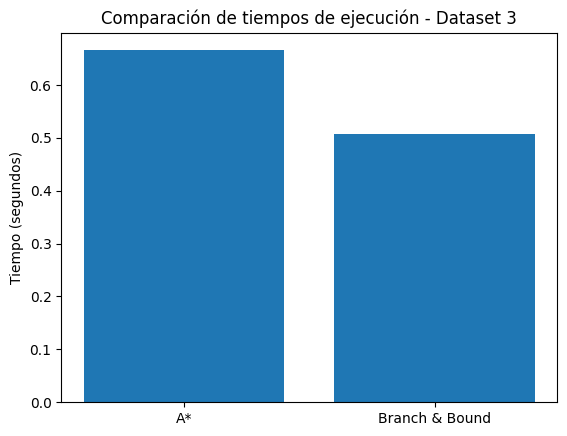

In [ ]:
import matplotlib.pyplot as plt

algoritmos = ["A*", "Branch & Bound"]
tiempos = [tiempo_astar_3, tiempo_bnb_3]

plt.bar(algoritmos, tiempos)
plt.ylabel("Tiempo (segundos)")
plt.title("Comparación de tiempos de ejecución - Dataset 3")
plt.show()


## Conclusión

Como ya se mencionó antes, para la resolución de este problema se usaron 2 algoritmos:
- **A\*:** Como método heurístico que encuentra soluciones de alta calidad en menor tiempo.
- **Branch & Bound:** Como método exacto que garantiza la solución óptima mediante poda de ramas no prometedoras.

Ambos algoritmos demostraron su utilidad para analizar el equilibrio entre tiempo de ejecución y calidad de la solución.  
A\* permite obtener resultados rápidos y cercanos al óptimo, mientras que Branch & Bound confirma la optimalidad pero con mayor costo computacional.

En conclusión, el modelo logra representar adecuadamente la gestión óptima del tiempo de un estudiante, integrando elementos de planificación, búsqueda y optimización vistos en el curso.
